In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from stDCL import *
from utils import clustering
import argparse

2024-04-17 13:32:49.137391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 13:32:54.945119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-17 13:32:54.945441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-17 13:32:54.945456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [3]:
parser = argparse.ArgumentParser(description='stDCL', formatter_class=argparse.ArgumentDefaultsHelpFormatter)

# setting
parser.add_argument('--cuda', type=bool, default=True)
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--dataset', type=str, default="E9.5_E1S1")
parser.add_argument('--datatype', type=str, default="Stereo")
parser.add_argument('--n_clusters', type=int, default=22)
parser.add_argument('--prelr', type=float, default=0.001)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--pre_epochs', type=int, default=500)
parser.add_argument('--epochs', type=int, default=1000)
parser.add_argument('--noise', type=int, default=1)
parser.add_argument('--lambda1', type=float, default=5.0)
parser.add_argument('--lambda2', type=float, default=0.1)
parser.add_argument('--lambda3', type=float, default=0.8)
parser.add_argument('--input', type=int, default=3000)
parser.add_argument('--latent_dim', type=int, default=64)
parser.add_argument('--n_neighbors', type=int, default=3, help='parameter k in spatial graph')
parser.add_argument('--n_neighbors_gene', type=int, default=1, help='parameter k in spatial graph')
parser.add_argument('--clustertype', type=str, default="leiden")
parser.add_argument('--preprocess', type=bool, default=True)
parser.add_argument('--radius', type=int, default=50)
args, unknown = parser.parse_known_args()

In [8]:
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = './lib/R'
os.environ['R_USER'] = './lib/python3.8/site-packages/rpy2'

adata = sc.read_h5ad("./Embryo/E9.5_E1S1.MOSTA.h5ad")
adata.var_names_make_unique()
adata = train(adata, args)

clustering(adata, args, refinement=False)

/home/yuzhuohan/miniconda2/envs/stDCL_env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
  1%|          | 5/500 [00:00<00:12, 40.45it/s]

Begin to train


100%|██████████| 1000/1000 [00:46<00:00, 21.68it/s]


Optimization finished
Searching resolution...
resolution=1.989999999999999, cluster number=30
resolution=1.979999999999999, cluster number=30
resolution=1.969999999999999, cluster number=30
resolution=1.959999999999999, cluster number=29
resolution=1.949999999999999, cluster number=29
resolution=1.939999999999999, cluster number=29
resolution=1.9299999999999993, cluster number=28
resolution=1.9199999999999993, cluster number=28
resolution=1.9099999999999993, cluster number=28
resolution=1.8999999999999992, cluster number=28
resolution=1.8899999999999992, cluster number=29
resolution=1.8799999999999992, cluster number=29
resolution=1.8699999999999992, cluster number=29
resolution=1.8599999999999992, cluster number=28
resolution=1.8499999999999992, cluster number=29
resolution=1.8399999999999992, cluster number=29
resolution=1.8299999999999992, cluster number=29
resolution=1.8199999999999992, cluster number=28
resolution=1.8099999999999992, cluster number=29
resolution=1.7999999999999992

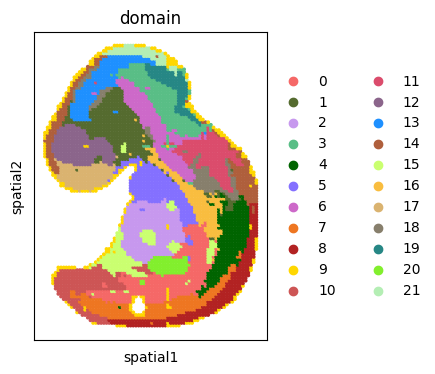

In [13]:
import matplotlib.pyplot as plt
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (3, 4)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
        "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
        "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
        "#877F6C","#268785", '#82EF2D', '#B4EEB4',
        "#ED282B","#F7AE42","#23206F"]
sc.pl.embedding(adata, basis="spatial",
                color="domain",
                s=30,
                show=True,
                palette=plot_color)

/home/yuzhuohan/miniconda2/envs/stDCL_env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_86980/1282064600.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['domain']=prelabel


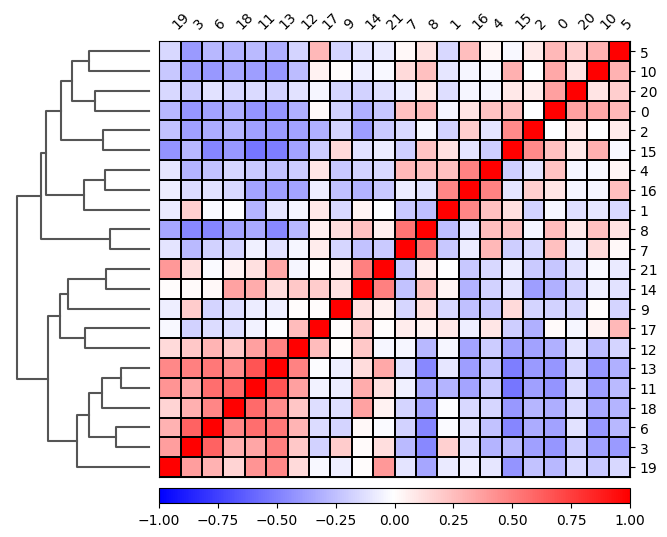

In [3]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
adata=adata[:, adata.var['highly_variable']]

sc.pl.correlation_matrix(adata, 'domain', figsize=(8,6),show=True)